In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
                                                                            
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow import keras

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = pd.read_csv('/kaggle/input/spotify/dataset.csv')

/kaggle/input/spotify/dataset.csv


# Начало

### смотрим состав таблицы, как она вообще выглядит, из чего состоит, какие типы данных в таблице

In [3]:
data.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [4]:
data.dtypes

Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

### проверяем на пустые ячейки

In [5]:
data.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

пустые ячейки только в тестовых данных, которые позже не понадобятся, поэтому их их можно не заполнять

In [6]:
data = data.dropna()
data.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

### проверяем на непонятные выбросы, данные

In [7]:
data.describe()

Unnamed: 0     popularity   duration_ms   danceability  \
count  113999.000000  113999.000000  1.139990e+05  113999.000000   
mean    56999.421925      33.238827  2.280312e+05       0.566801   
std     32909.243463      22.304959  1.072961e+05       0.173543   
min         0.000000       0.000000  8.586000e+03       0.000000   
25%     28499.500000      17.000000  1.740660e+05       0.456000   
50%     56999.000000      35.000000  2.129060e+05       0.580000   
75%     85499.500000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        0.641383       5.309126      -8.258950       0.637558   
std         0.251530       3.559999       5.029357       0.480708   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  113999.000000  113999.000000     113999.000000  113999.000000   
mean        0.084652       0.314907          0.156051       0.213554   
std         0.105733       0.332522          0.309556       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.597500          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  113999.000000  113999.000000   113999.000000  
mean        0.474066     122.147695        3.904034  
std         0.259261      29.978290        0.432623  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218500        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

### удаляем не нужные столбцы, которые ни как не вляют на популярность музыки и не понадобятся при анализе

In [8]:
data = data.drop(labels = ['track_id', 'artists', 'track_name', 'album_name'], axis = 1)
data = data.drop_duplicates()

<Axes: >

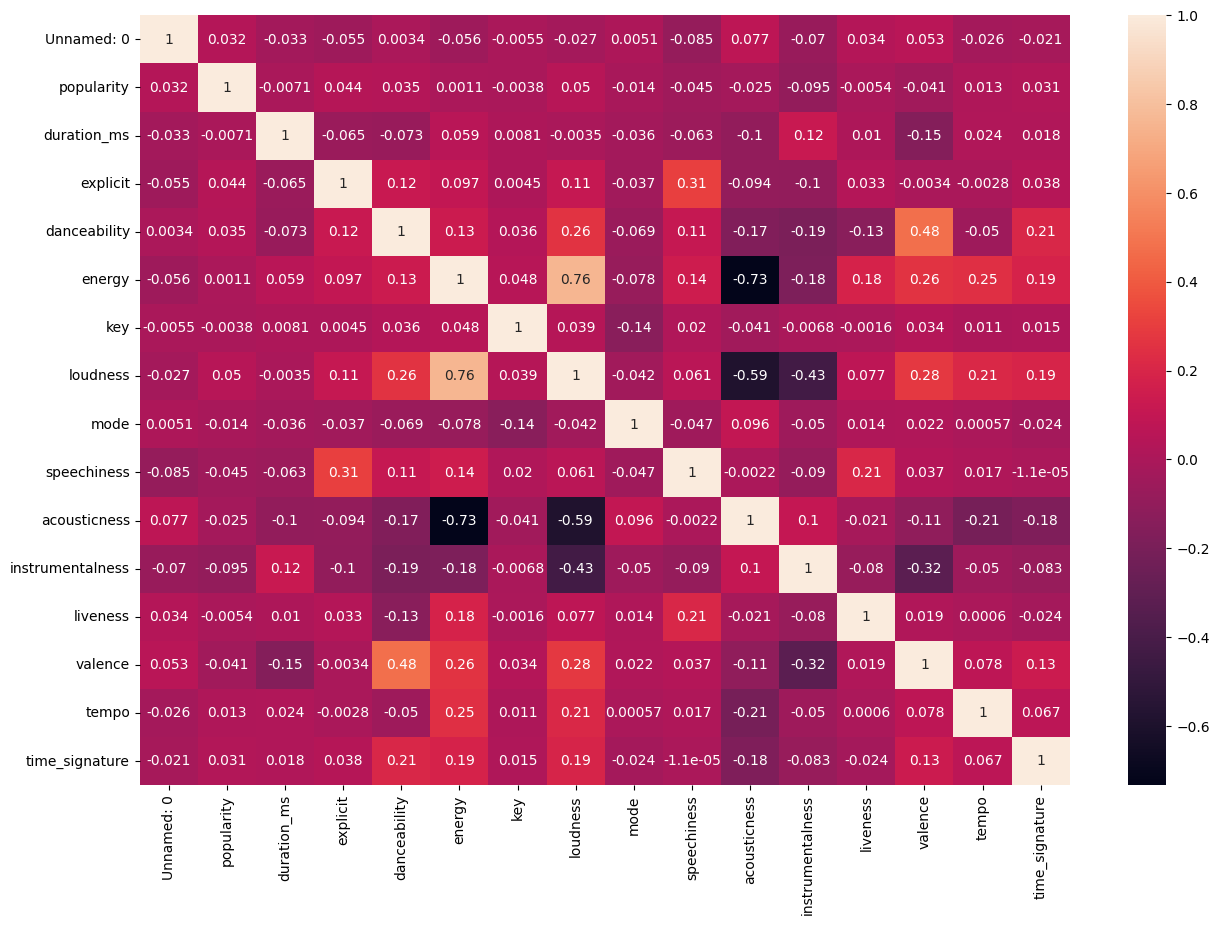

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(data.drop(columns=['track_genre']).corr(),annot=True)

# Гипотезы

Популярность трека сложно вывести только поимени исполнителя, названию альбома и названию самой песни. несмтря на то, что очень часто трек оказывается популярным и вирусным только из-за известности артиста, сложно не отрицать того факта, что только имени мало. поэтому надо найти закномерности, гипотезы в других данных.
Мои гипотезы:
1. Продолжительность трека. Зачастую треки с длиной окло трех минут становятся популярнее, чем треки с продолжительностью меньше (примерно 1.5 минуты) или больше (примерно 5 минут). Людям либо не интересно слушать небольшие песни, либо надоедает слушать трек более 3-4 минут
2. 18+ текст (explicit). Так как в е-треках зачастую подразумевают "запрещенные" темы или используются нецензурные выражения, то пометка explicit приводит к повышенному интересу слушателя
3. Танцевальность и энергичность. Если под трек можно поставить танец или он будет энергичным, то это может привести к его популярности на площадках по типу TikTok, что приведет к более частым прослушиванием 
4. Энергичность. Очень част люди любят энергичную музыку, под кторую мжно быстро двигаться, это может привести к популярности трека
5. Громкость. Зачастую, громкое музыка является так же и энергичной, что может привести в большим прослушиванием
6. Разговрность. Треки имеющие значение выше 0.66 состоят в основном из произнесённых слов, их можно отнести к рэпу, что является доволно популярным жанром в наше время
7. Темп. Из-за увеличения скорости, темпа жизни, люди предпочитают более быстрые треки
8. Жанр. В разное время популярны разные жанры
9. Акустичность. По мнению многих людей акустическая музыка боле приятна слуху, чем электическая
10. Позитивность. Есть мнение, что людям больше нравится слушать более позитивную музыку, которая задает хорее настроение
11. Лад. Мажорные песни считаются более позитивными, поэтому тут вывод как в 10 гипотезе
12. Живой звук. наличие живого звука создает ощущение присуствия, например, на концерте, поэтому многи людям это может больше нравиться
13. Инструментальность. Многие люди предпочитаю больше инструментал песни, чем её саму

## **1 Гипотеза**
### Продолжительность трека

In [10]:
data['duration_ms'] = data['duration_ms'] / 60000

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


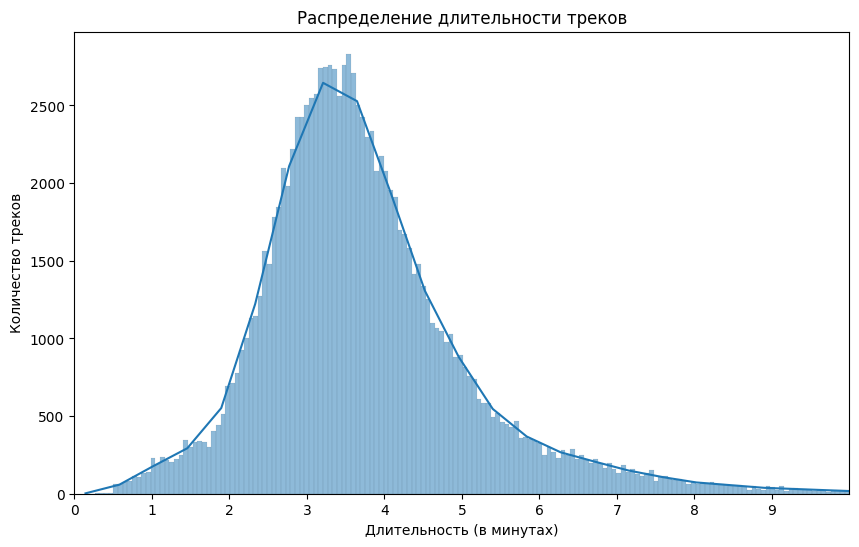

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data['duration_ms'], kde=True)
plt.title('Распределение длительности треков')
plt.xlabel('Длительность (в минутах)')
plt.xlim(0, 10)  
plt.xticks(np.arange(0, 10, 1))  
plt.ylabel('Количество треков')
plt.show()

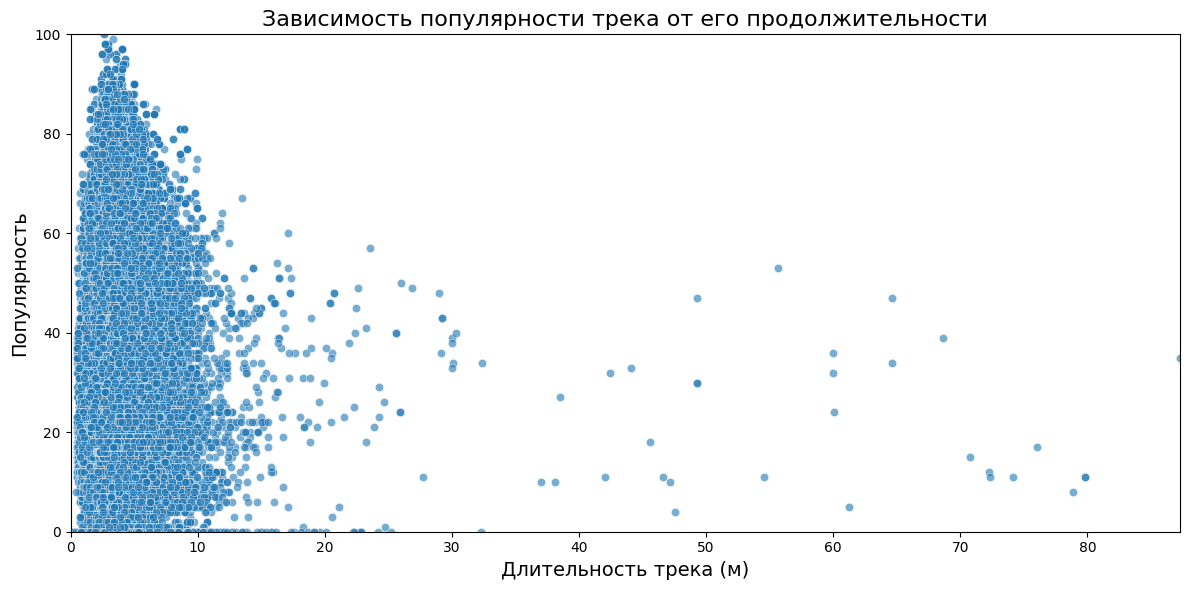

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='duration_ms', y='popularity', data=data, alpha=0.6)
plt.title('Зависимость популярности трека от его продолжительности', fontsize=16)
plt.xlabel('Длительность трека (м)', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, data['duration_ms'].max())  
plt.ylim(0, 100) 
plt.tight_layout()
plt.show()

### Вывод
Больше всего песен с длительность от двух до 5 минут, что является нормой для песен в наше время.
Из графика мы можем сделать вывод, что больше всего песен с длительность не более двух минут и самыми популярными являются песни с длительностью до минуты.

## **2 Гипотеза**
### 18+ текст

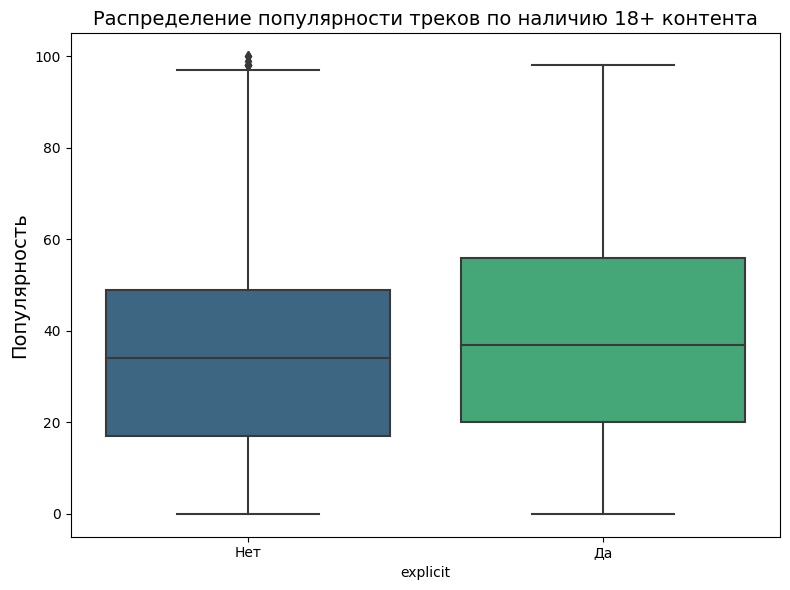

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='explicit', y='popularity', data=data, palette='viridis')
plt.title('Распределение популярности треков по наличию 18+ контента', size=14)
plt.ylabel('Популярность', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Нет', 'Да'])  
plt.tight_layout()
plt.show()

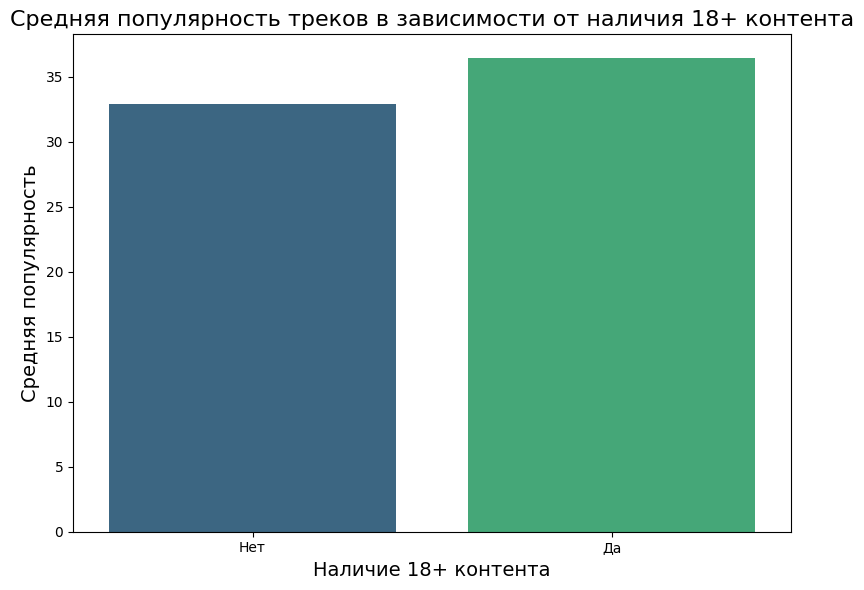

In [14]:
explicit_popularity = data.groupby('explicit')['popularity'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='explicit', y='popularity', data=explicit_popularity, palette='viridis')
plt.title('Средняя популярность треков в зависимости от наличия 18+ контента', fontsize=16)
plt.xlabel('Наличие 18+ контента', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Нет', 'Да']) 
plt.tight_layout()
plt.show()

### Вывод
Из двух графиков мы можем сделать вывод, что песни без 18+ контента чуть менее популярны, чем песни с ним. Разница минимальна, они на одном уровне

## **3 Гипотеза**
### Танцевальность

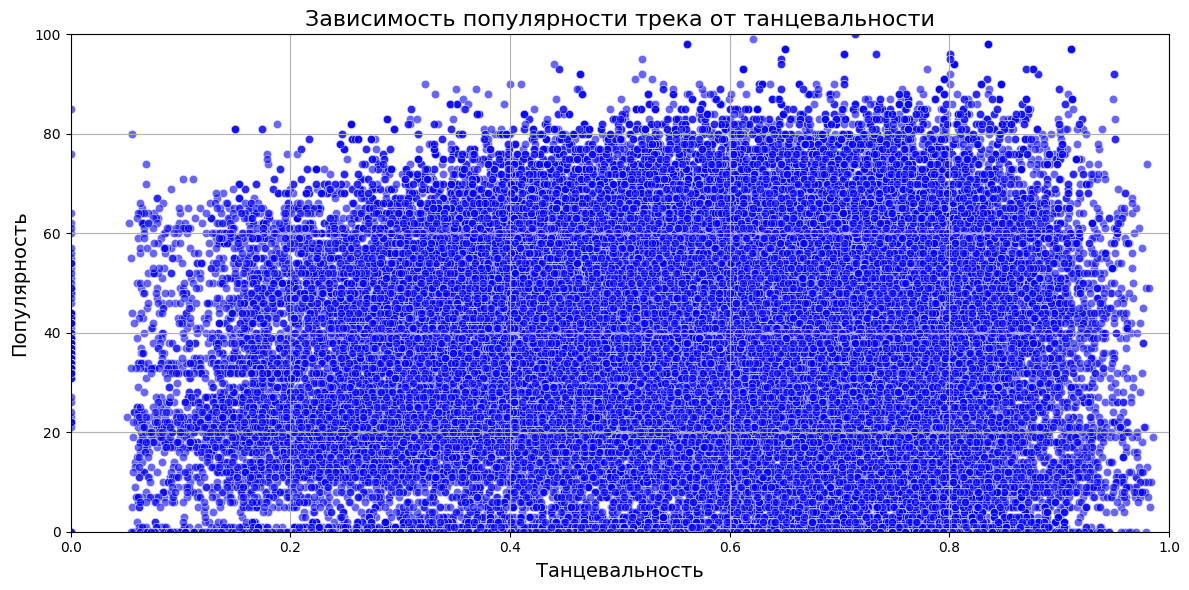

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='danceability', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от танцевальности', fontsize=16)
plt.xlabel('Танцевальность', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1) 
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

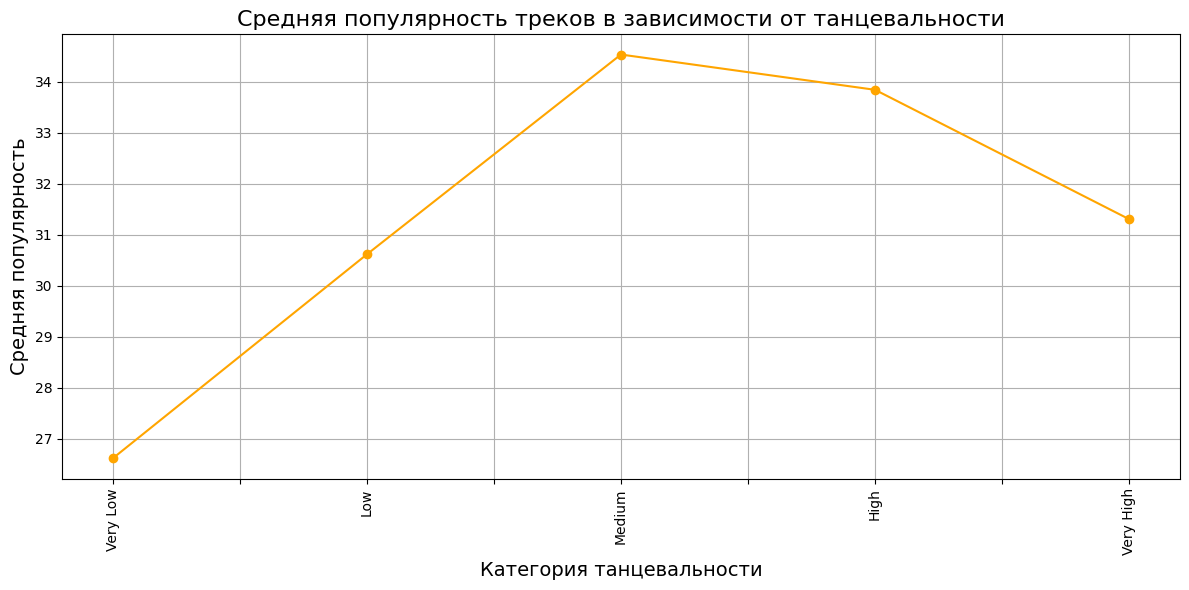

In [16]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['danceability_category'] = pd.cut(data['danceability'], bins=bins, labels=labels, right=False)

avg_popularity_by_danceability = data.groupby('danceability_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_danceability.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от танцевальности', fontsize=16)
plt.xlabel('Категория танцевальности', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Высокую популярность имеют песни со средней танцевальность, после идут уже более танцевальные и на третьем месте максимально танцевальные

## **4 Гипотеза**
### Энергичность

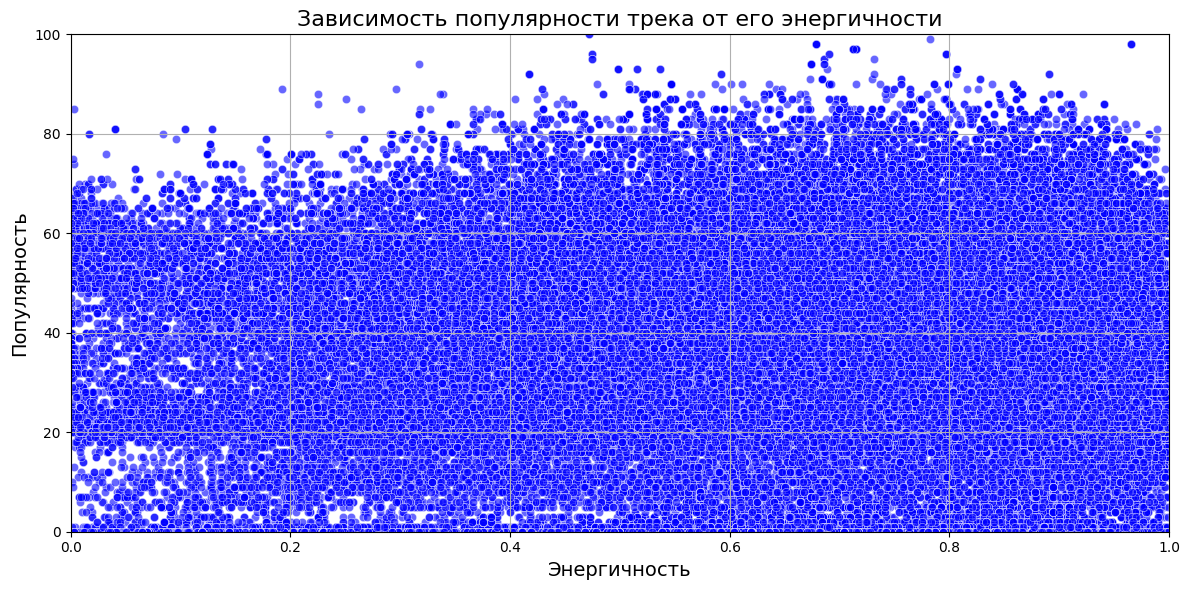

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='energy', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от его энергичности', fontsize=16)
plt.xlabel('Энергичность', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1)  
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

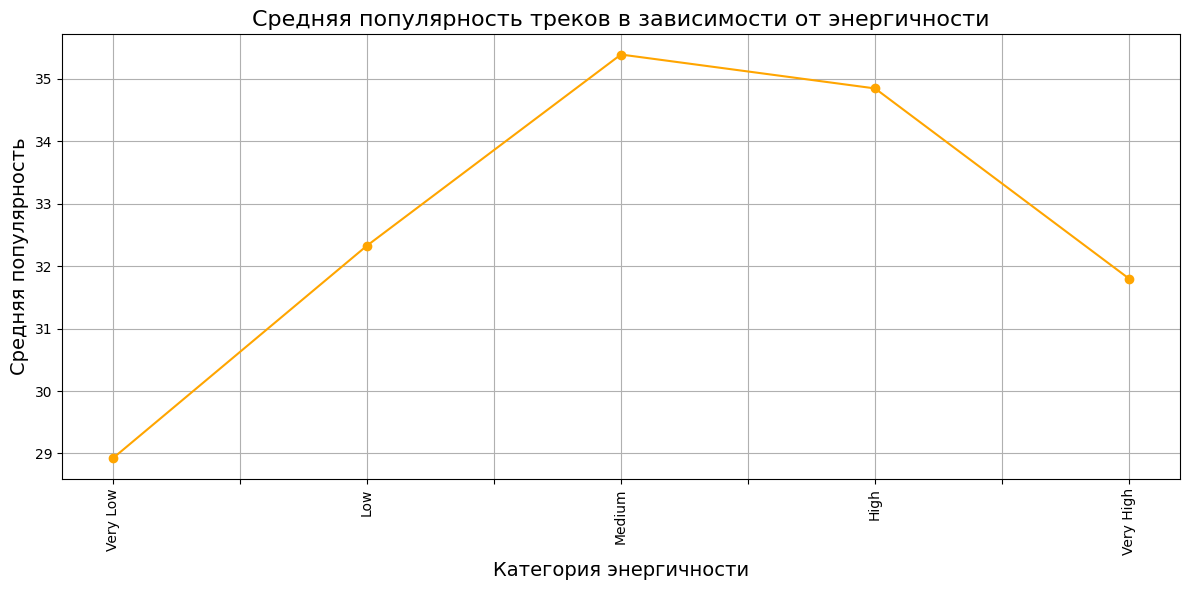

In [18]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['energy_category'] = pd.cut(data['energy'], bins=bins, labels=labels, right=False)

avg_popularity_by_energy = data.groupby('energy_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_energy.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от энергичности', fontsize=16)
plt.xlabel('Категория энергичности', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Высокую популярность имеют песни со средней энергичностью, после идут уже более энергичные и на третьем месте максимально энергичные

Мы можеи заметить, что графики танцевальности и энергичности почти идентичные, следовательно можно сделать вывод, что танцевальнсть, зачастую, зависит от энергичности, либо их значения похожи у каждой песни

## **5 Гипотеза**
### Громкость

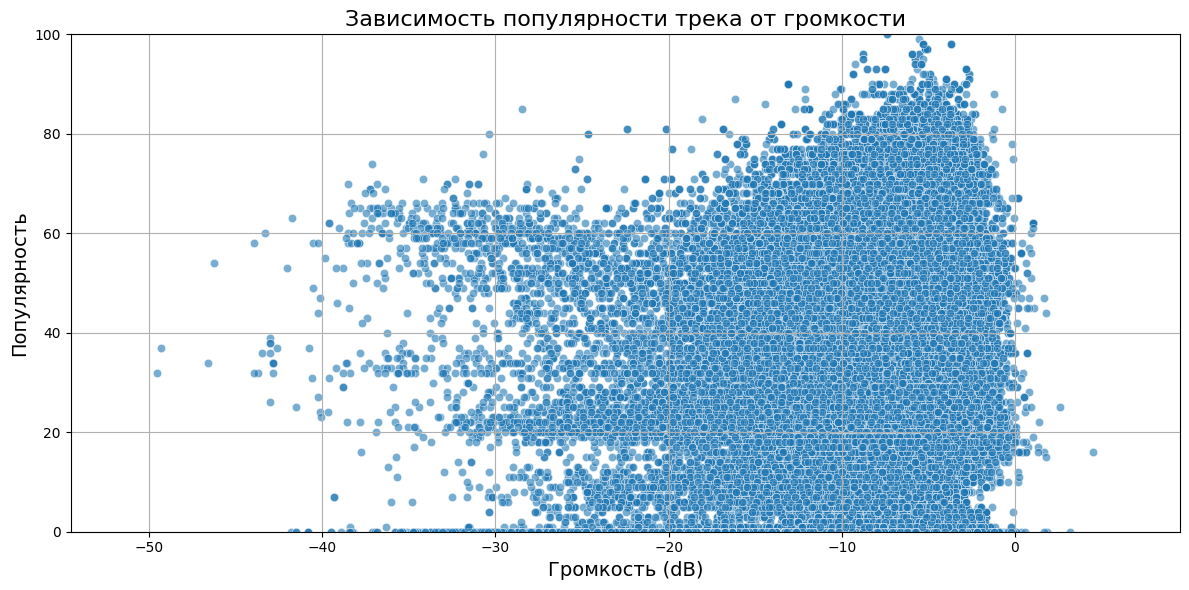

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='loudness', y='popularity', data=data, alpha=0.6)
plt.title('Зависимость популярности трека от громкости', fontsize=16)
plt.xlabel('Громкость (dB)', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(data['loudness'].min() - 5, data['loudness'].max() + 5)  
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

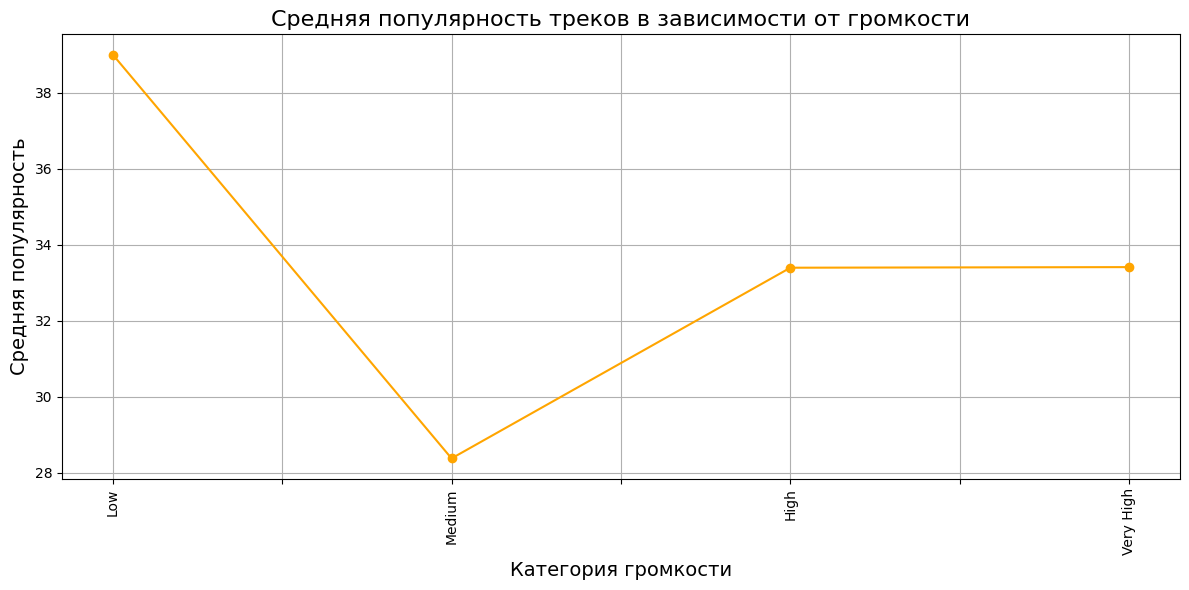

In [20]:
bins = [-50, -35, -20, -5, 10]  
labels = ['Low', 'Medium', 'High', 'Very High']
data['loudness_category'] = pd.cut(data['loudness'], bins=bins, labels=labels)

avg_popularity_by_loudness = data.groupby('loudness_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_loudness.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от громкости', fontsize=16)
plt.xlabel('Категория громкости', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Можно сказать. что из всех представленных треков, особую популярность имеют громкие, но не самые, треки

## **6 Гипотеза**
### Разговорность

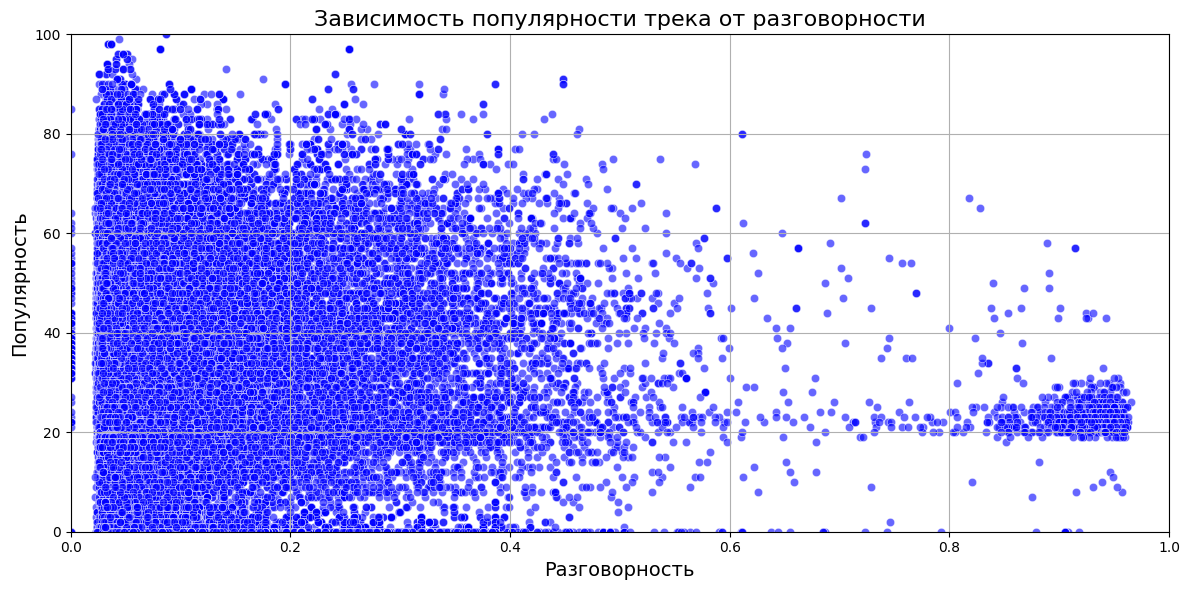

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='speechiness', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от разговорности', fontsize=16)
plt.xlabel('Разговорность', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1) 
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

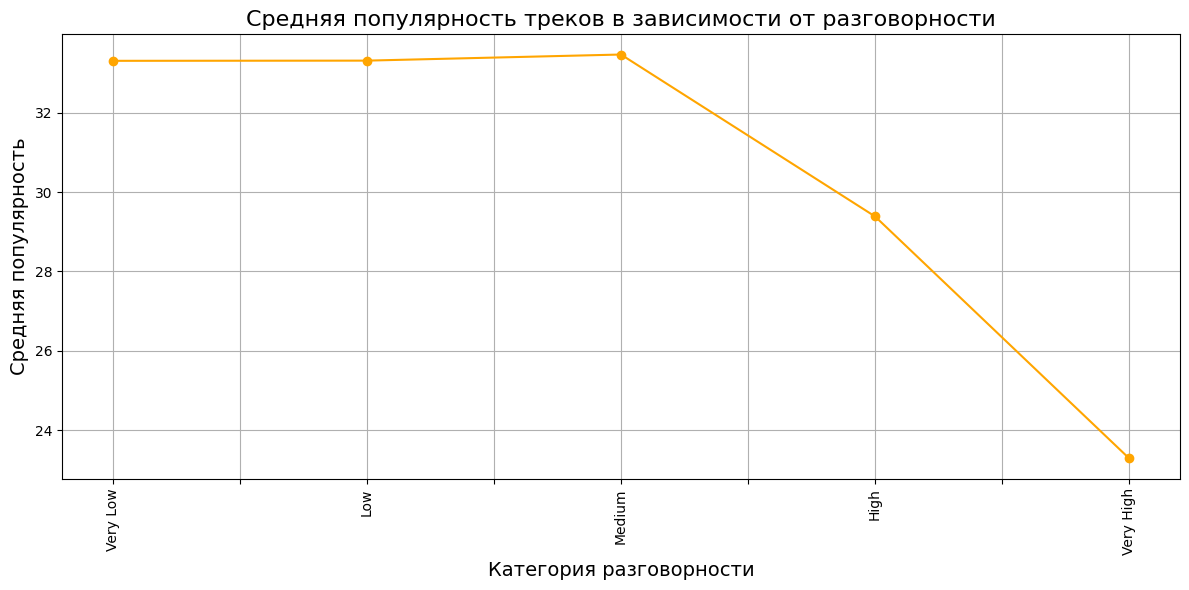

In [22]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0] 
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['speechiness_category'] = pd.cut(data['speechiness'], bins=bins, labels=labels, right=False)

avg_popularity_by_speechiness = data.groupby('speechiness_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_speechiness.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от разговорности', fontsize=16)
plt.xlabel('Категория разговорности', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Самыми популярными являются более класические в общем понимание песни, без огромной разговорности, без "рэпа"

## **7 Гипотеза**
### Темп

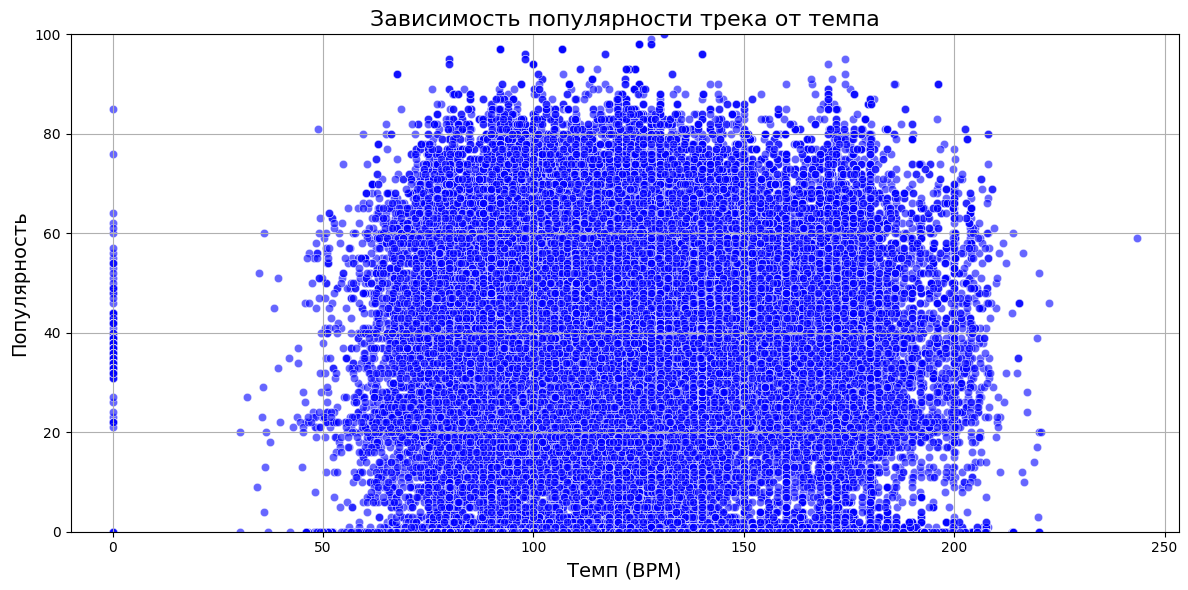

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='tempo', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от темпа', fontsize=16)
plt.xlabel('Темп (BPM)', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(data['tempo'].min() - 10, data['tempo'].max() + 10)  
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

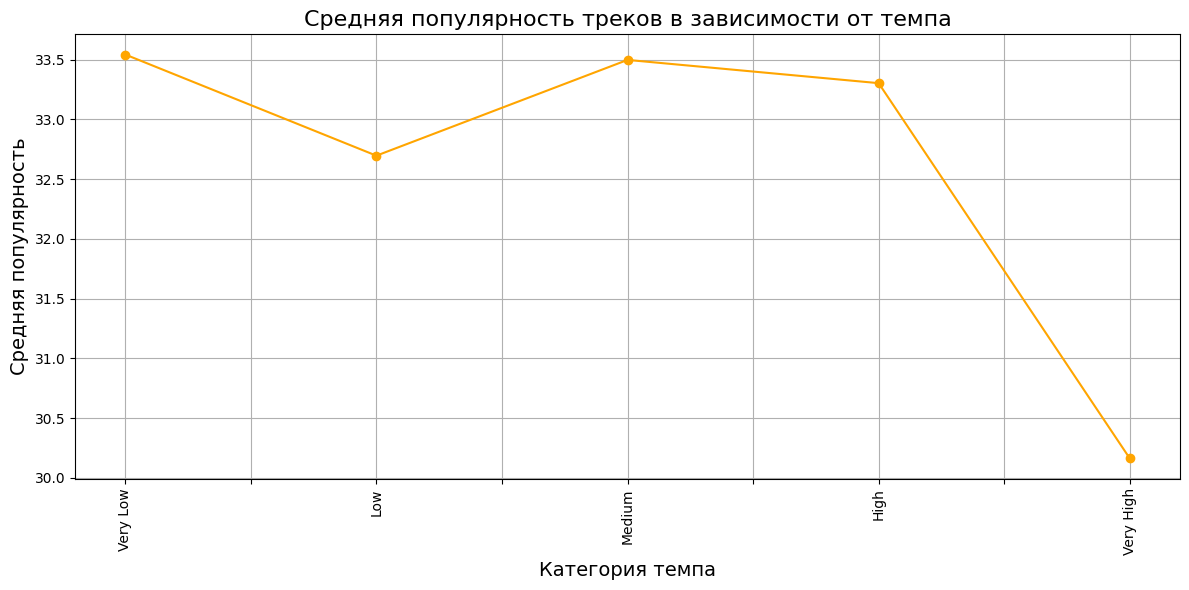

In [24]:
bins = [0, 50, 100, 150, 200, 250]  
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['tempo_category'] = pd.cut(data['tempo'], bins=bins, labels=labels, right=False)

avg_popularity_by_tempo = data.groupby('tempo_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_tempo.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от темпа', fontsize=16)
plt.xlabel('Категория темпа', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Самые популярные песни во средним темпом

## **8 Гипотеза**
### Жанр

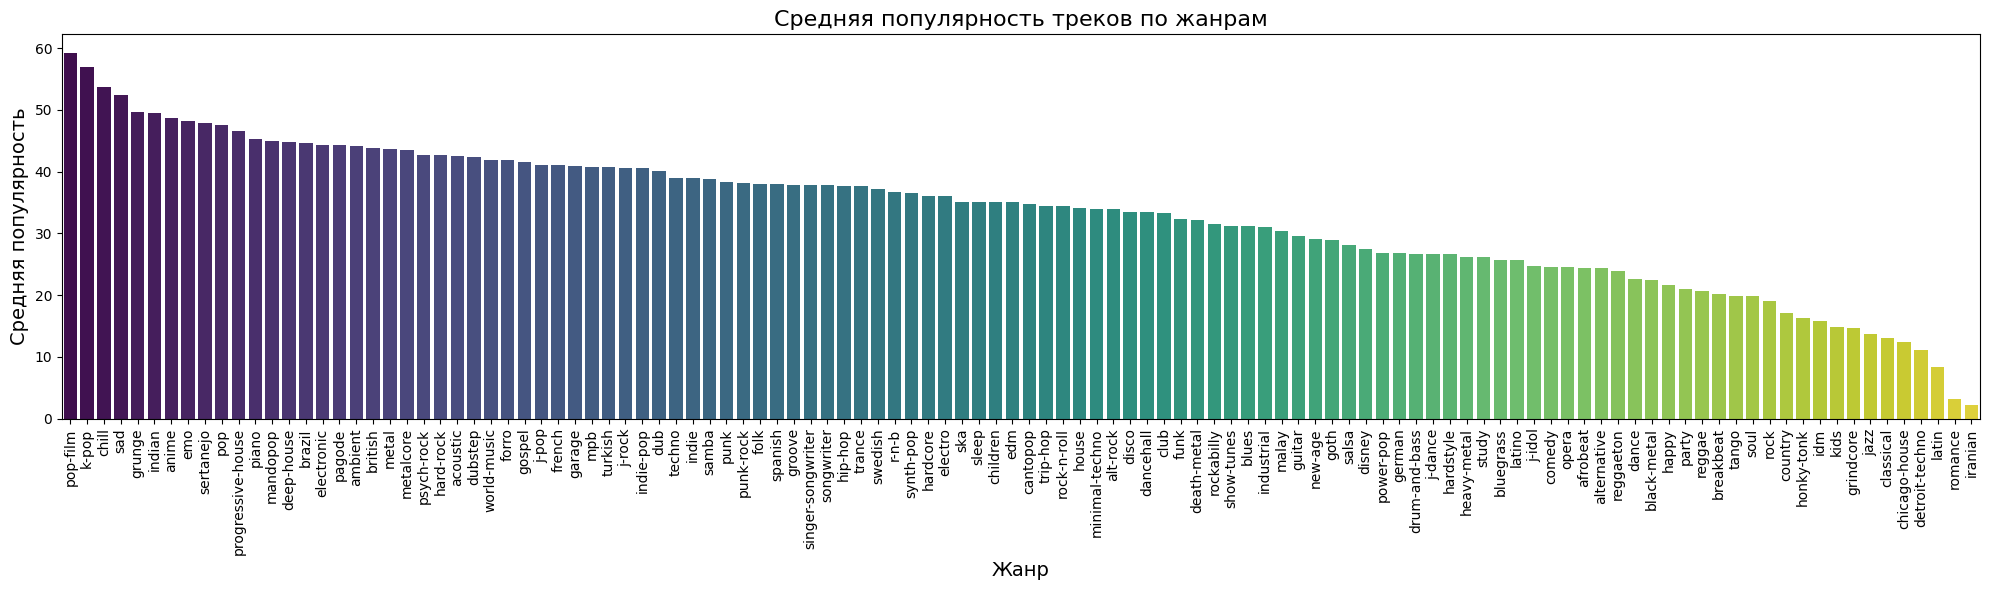

In [25]:
genre_popularity = data.groupby('track_genre')['popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(20, 6))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette='viridis')
plt.title('Средняя популярность треков по жанрам', fontsize=16)
plt.xlabel('Жанр', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Вывод
Топ 5 самых популярных жанров: pop-film, k-pop, chill, sad, grunge

## **9 Гипотеза**
### Акустичность

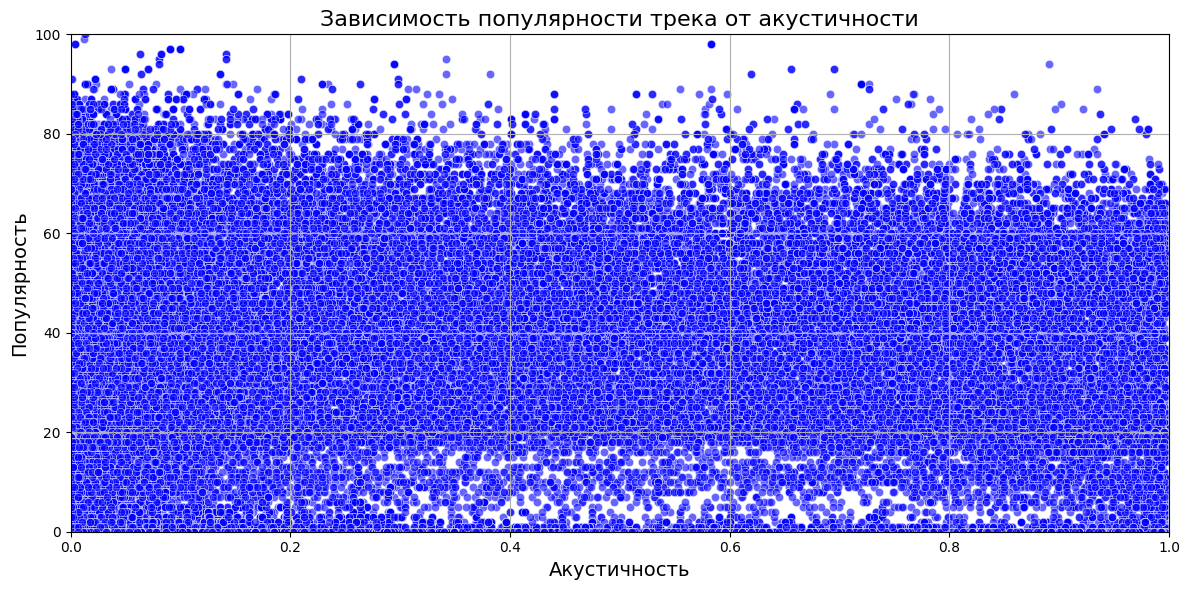

In [26]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='acousticness', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от акустичности', fontsize=16)
plt.xlabel('Акустичность', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1)  
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

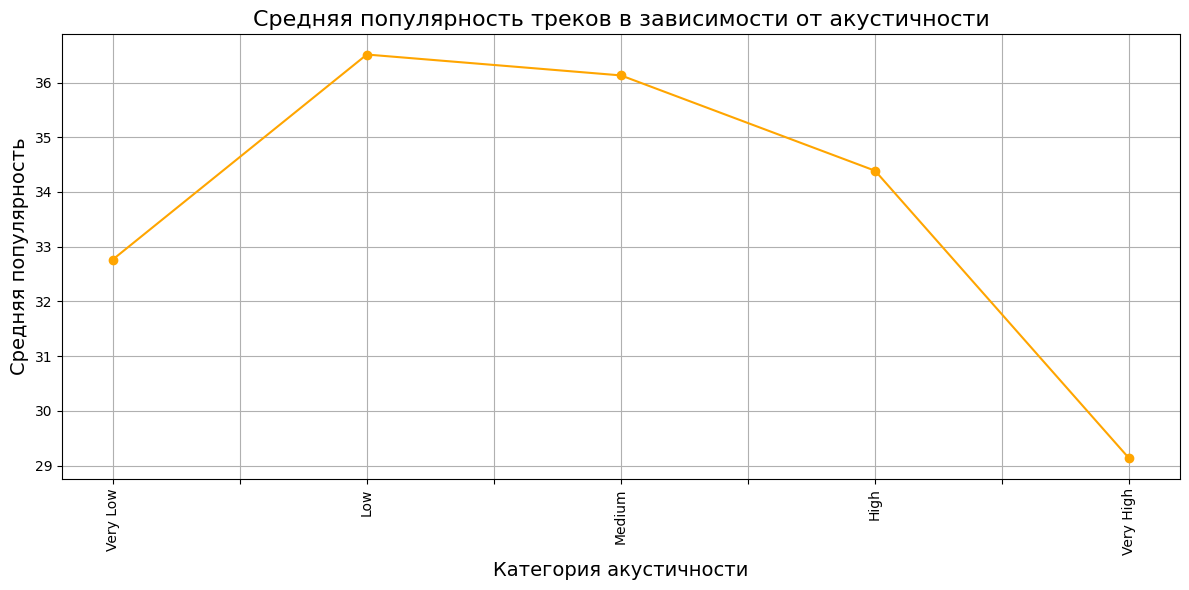

In [27]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0] 
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['acousticness_category'] = pd.cut(data['acousticness'], bins=bins, labels=labels, right=False)

avg_popularity_by_acousticness = data.groupby('acousticness_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_acousticness.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от акустичности', fontsize=16)
plt.xlabel('Категория акустичности', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
песни с малым или средним колическом акустики являются более популярными

## **10 Гипотеза**
### Позитивность

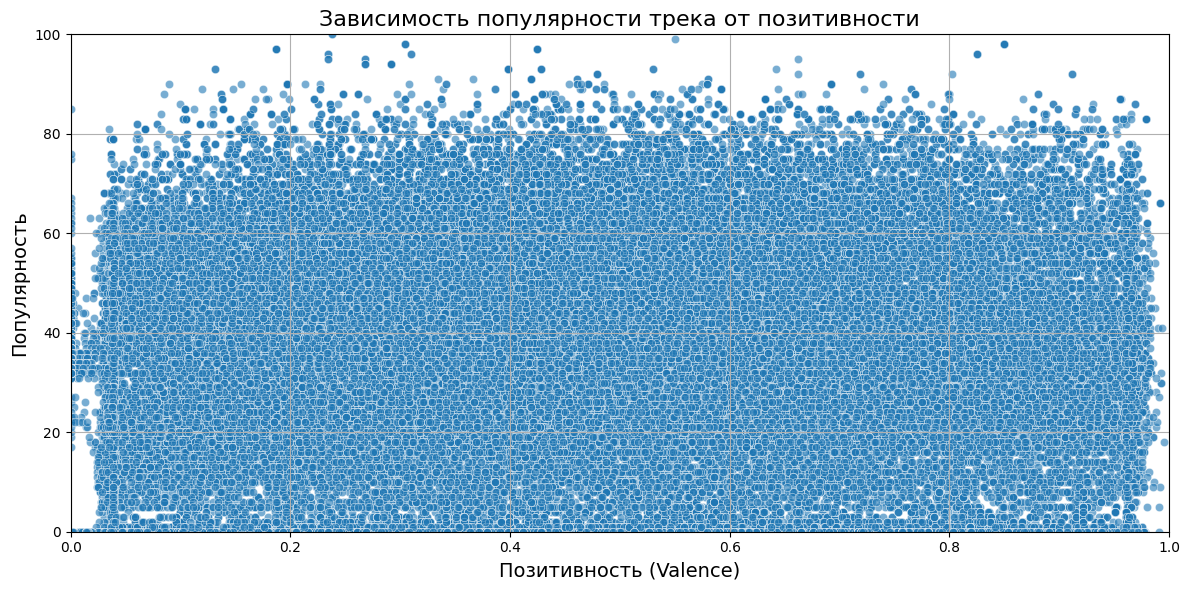

In [28]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='valence', y='popularity', data=data, alpha=0.6)
plt.title('Зависимость популярности трека от позитивности', fontsize=16)
plt.xlabel('Позитивность (Valence)', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1)  
plt.ylim(0, 100) 
plt.grid()
plt.tight_layout()
plt.show()

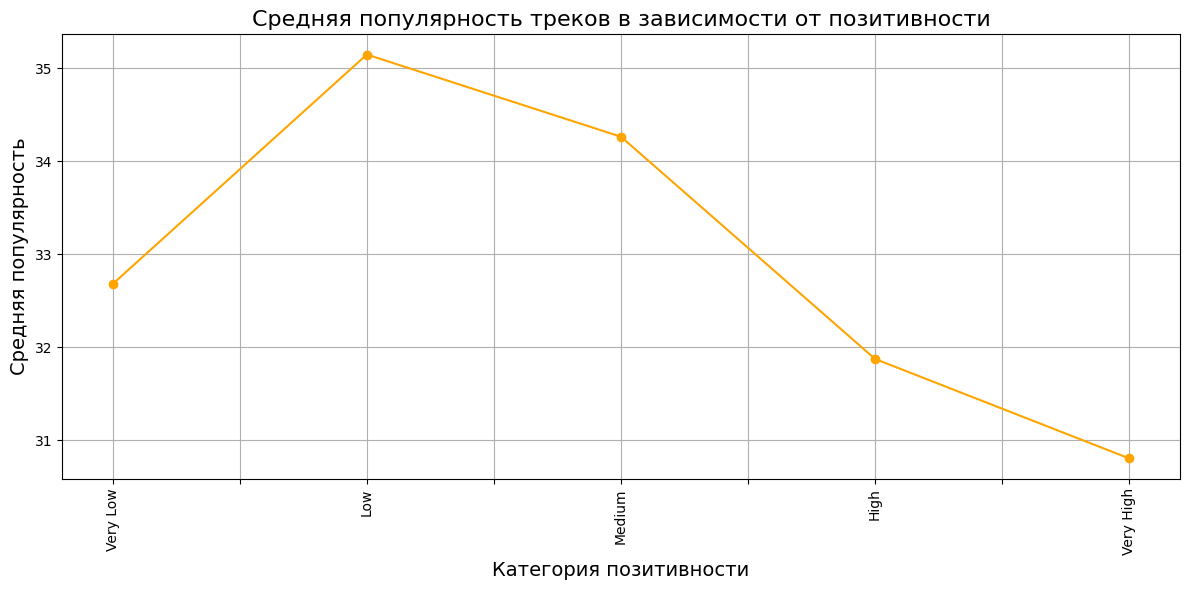

In [29]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['valence_category'] = pd.cut(data['valence'], bins=bins, labels=labels, right=False)

avg_popularity_by_valence = data.groupby('valence_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_valence.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от позитивности', fontsize=16)
plt.xlabel('Категория позитивности', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Менее позитивные треки являются более популярными чем наиболее позитивные 

## **11 Гипотеза**
### Лад

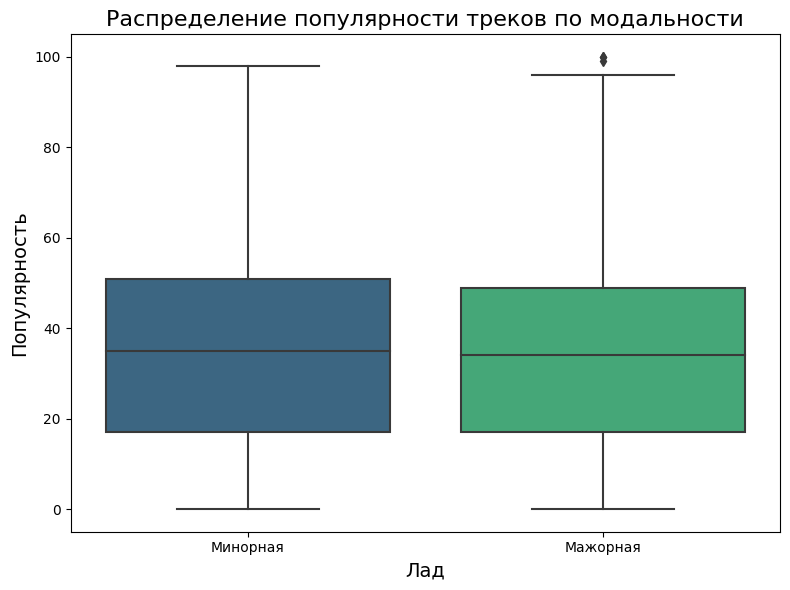

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='mode', y='popularity', data=data, palette='viridis')
plt.title('Распределение популярности треков по модальности', fontsize=16)
plt.xlabel('Лад', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Минорная', 'Мажорная'])  
plt.tight_layout()
plt.show()

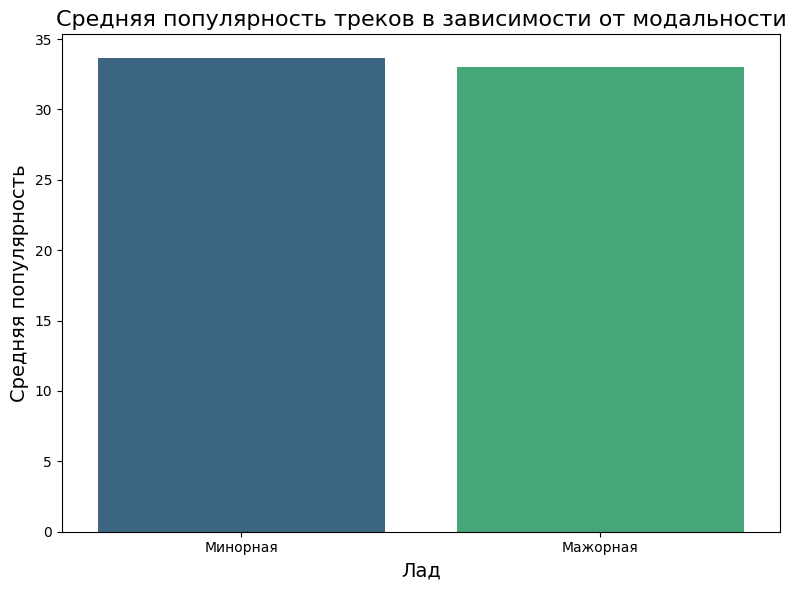

In [31]:
modal_popularity = data.groupby('mode')['popularity'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='mode', y='popularity', data=modal_popularity, palette='viridis')
plt.title('Средняя популярность треков в зависимости от модальности', fontsize=16)
plt.xlabel('Лад', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Минорная', 'Мажорная'])  
plt.tight_layout()
plt.show()

### Вывод
Из двух графиков мы можем сделать вывод, что песни в мажоре чуть менее популярны, чем песни в миноре. Разница минимальна, они на одном уровне

## **12 Гипотеза**
### Живой звук

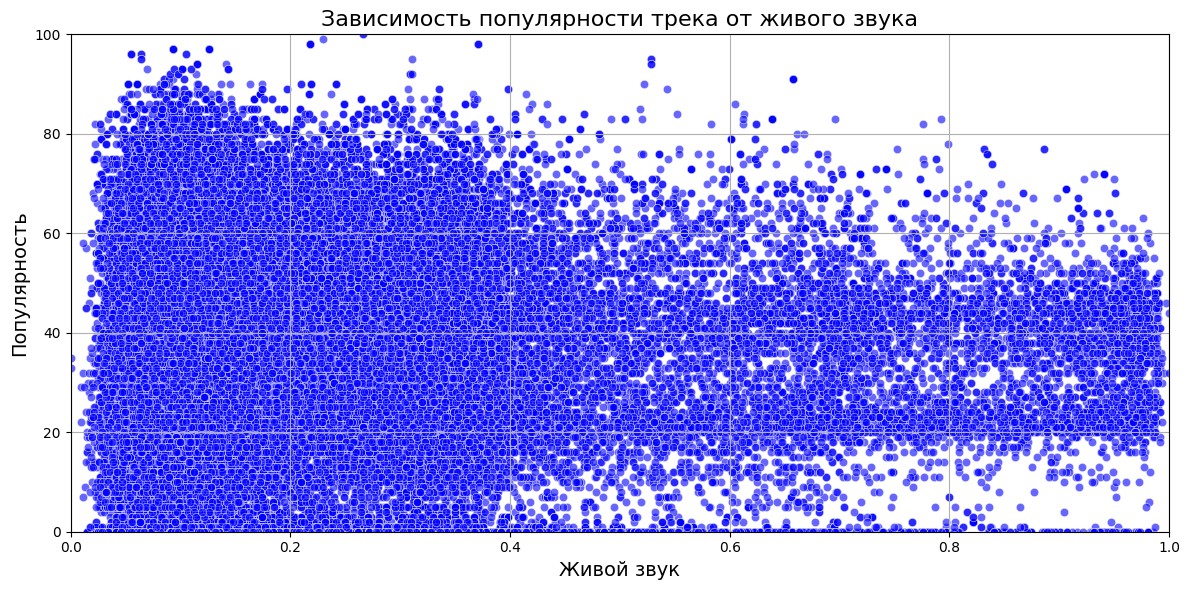

In [32]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='liveness', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от живого звука', fontsize=16)
plt.xlabel('Живой звук', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1)  
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

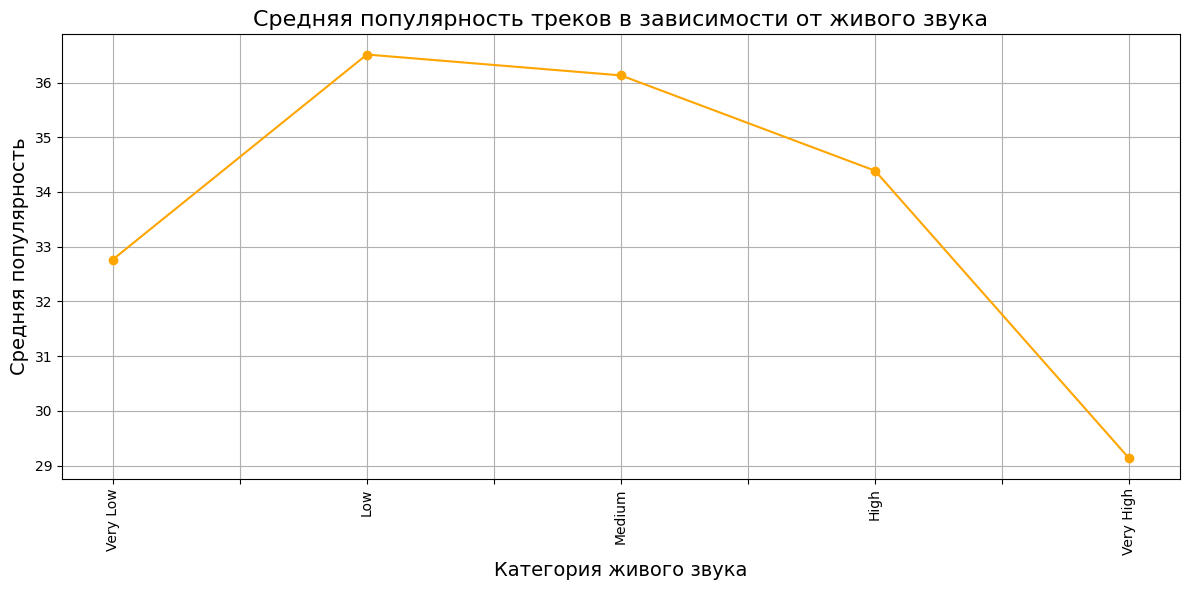

In [33]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0] 
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['liveness_category'] = pd.cut(data['liveness'], bins=bins, labels=labels, right=False)

avg_popularity_by_acousticness = data.groupby('acousticness_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_acousticness.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от живого звука', fontsize=16)
plt.xlabel('Категория живого звука', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Более популярны песни с низким содержанием живого звука

## **13 Гипотеза**
### Инструментальность

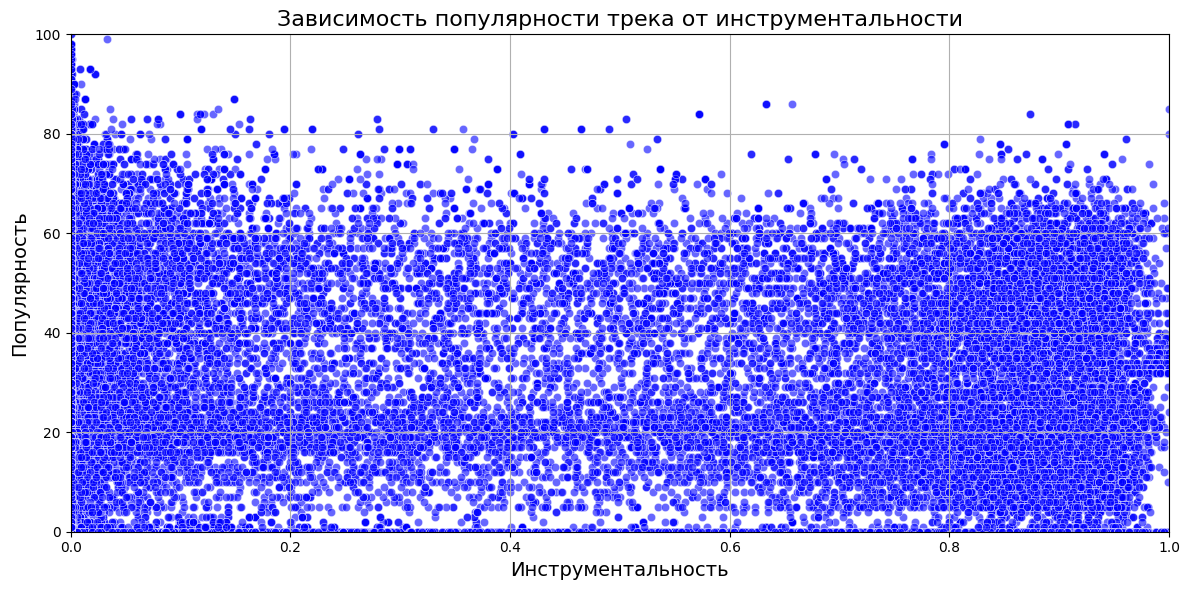

In [34]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='instrumentalness', y='popularity', data=data, alpha=0.6, color='blue')
plt.title('Зависимость популярности трека от инструментальности', fontsize=16)
plt.xlabel('Инструментальность', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xlim(0, 1)  
plt.ylim(0, 100)  
plt.grid()
plt.tight_layout()
plt.show()

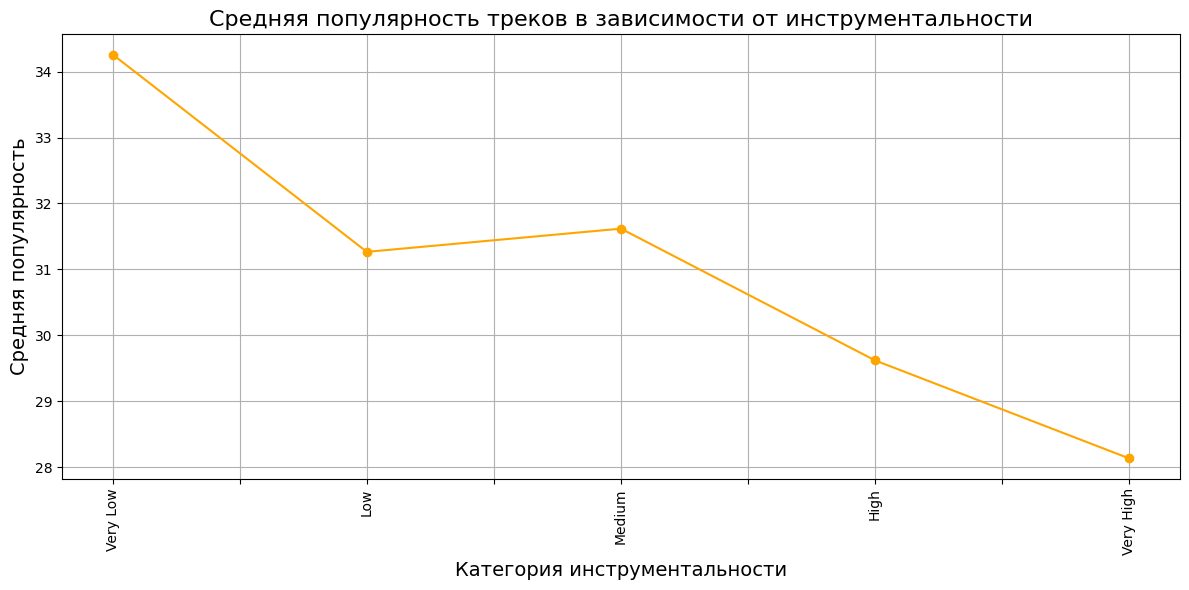

In [35]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
data['instrumentalness_category'] = pd.cut(data['instrumentalness'], bins=bins, labels=labels, right=False)

avg_popularity_by_instrumentalness = data.groupby('instrumentalness_category', observed=False)['popularity'].mean()

plt.figure(figsize=(12, 6))
avg_popularity_by_instrumentalness.plot(kind='line', marker='o', color='orange')
plt.title('Средняя популярность треков в зависимости от инструментальности', fontsize=16)
plt.xlabel('Категория инструментальности', fontsize=14)
plt.ylabel('Средняя популярность', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

### Вывод
Наибольшую популярность имеют треки с низким либо среднем уровнем инструментальности

## Общий вывод

Можно сказать, что популярность в большинстве случаев не зависит от наличия 18+ контента, от лада, в котором написана музыка. Остальные критерии в той или иной степени влияют на популярность трека.

# Модели

удаление данных,которые мы создали, для нализа и ктрые не нужны для модели

In [36]:
data = data.drop(labels = ['instrumentalness_category', 
                           'liveness_category', 
                           'danceability_category', 
                           'energy_category', 
                           'loudness_category', 
                           'speechiness_category', 
                           'tempo_category', 
                           'acousticness_category', 
                           'valence_category'], axis = 1)

In [37]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

## Простая модель

In [38]:
X = data.drop(columns=['popularity'])  
y = data['popularity']  

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE {mae:.2f}')
print(f'MSE {mse:.2f}')
print(f'RMSE {rmse:.2f}')

MAE 18.30
MSE 482.19
RMSE 21.96


## Линейная модель


In [42]:
# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказания на тестовом наборе
pred = model.predict(X_test)

# Метрики для тестового набора
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5

print(f'MAE {mae:.2f}')
print(f'MSE {mse:.2f}')
print(f'RMSE {rmse:.2f}')

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mae = []
fold_mse = []
fold_rmse = []

for train_index, test_index in kf.split(X_train):
    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_fold_train, y_fold_train)
    fold_pred = model.predict(X_fold_test)

    fold_mae.append(mean_absolute_error(y_fold_test, fold_pred))
    fold_mse.append(mean_squared_error(y_fold_test, fold_pred))
    fold_rmse.append(fold_mse[-1] ** 0.5)

# Вывод метрик для каждого фолда
for i in range(len(fold_mae)):
    print(f'Фолд {i + 1}: MAE {fold_mae[i]:.2f}, MSE {fold_mse[i]:.2f}, RMSE {fold_rmse[i]:.2f}')

# Среднее значение кросс-валидации
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Среднее значение кросс-валидации: {scores.mean():.4f}')

MAE 18.30
MSE 482.19
RMSE 21.96
Фолд 1: MAE 18.29, MSE 484.28, RMSE 22.01
Фолд 2: MAE 18.37, MSE 485.53, RMSE 22.03
Фолд 3: MAE 18.33, MSE 483.53, RMSE 21.99
Фолд 4: MAE 18.30, MSE 481.36, RMSE 21.94
Фолд 5: MAE 18.41, MSE 487.44, RMSE 22.08
Среднее значение кросс-валидации: 0.0268


## Деревья решений

In [43]:
# Определение модели
model = DecisionTreeRegressor()

# Определение параметров для GridSearch
param_grid = {
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [3, 6, 9],
    "min_samples_leaf": [1, 3, 5]
}

# GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры и лучший MSE
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f'Лучшие параметры: {best_params}')
print(f'Лучший MSE: {best_score:.2f}')

# Обучение модели с лучшими параметрами
tree = DecisionTreeRegressor(max_depth=best_params['max_depth'], 
                              min_samples_split=best_params['min_samples_split'], 
                              min_samples_leaf=best_params['min_samples_leaf'])
tree.fit(X_train, y_train)

# Предсказания на тестовом наборе
pred = tree.predict(X_test)

# Метрики для тестового набора
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5

print(f'MAE {mae:.2f}')
print(f'MSE {mse:.2f}')
print(f'RMSE {rmse:.2f}')

# Кросс-валидация с выводом метрик для каждого фолда
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mae = []
fold_mse = []
fold_rmse = []

for train_index, test_index in kf.split(X_train):
    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    tree.fit(X_fold_train, y_fold_train)
    fold_pred = tree.predict(X_fold_test)

    fold_mae.append(mean_absolute_error(y_fold_test, fold_pred))
    fold_mse.append(mean_squared_error(y_fold_test, fold_pred))
    fold_rmse.append(fold_mse[-1] ** 0.5)

# Вывод метрик для каждого фолда
for i in range(len(fold_mae)):
    print(f'Фолд {i + 1}: MAE {fold_mae[i]:.2f}, MSE {fold_mse[i]:.2f}, RMSE {fold_rmse[i]:.2f}')

# Среднее значение кросс-валидации
scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Среднее значение кросс-валидации: {-scores.mean():.4f}')


Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 3}
Лучший MSE: 368.97
MAE 13.46
MSE 365.19
RMSE 19.11
Фолд 1: MAE 13.55, MSE 376.02, RMSE 19.39
Фолд 2: MAE 13.56, MSE 379.23, RMSE 19.47
Фолд 3: MAE 12.71, MSE 355.73, RMSE 18.86
Фолд 4: MAE 13.27, MSE 368.03, RMSE 19.18
Фолд 5: MAE 13.23, MSE 374.12, RMSE 19.34
Среднее значение кросс-валидации: 369.0095


## Градиентный бустинг

In [44]:
# Определение модели
grad = GradientBoostingRegressor(max_depth=6, n_estimators=50, learning_rate=0.1)

# Обучение модели на тренировочных данных
grad.fit(X_train, y_train)

# Предсказания на тестовом наборе
pred = grad.predict(X_test)

# Метрики для тестового набора
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5

print(f'MAE {mae:.2f}')
print(f'MSE {mse:.2f}')
print(f'RMSE {rmse:.2f}')

# Кросс-валидация с выводом метрик для каждого фолда
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mae = []
fold_mse = []
fold_rmse = []

for train_index, test_index in kf.split(X_train):
    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Обучение модели на текущем фолде
    grad.fit(X_fold_train, y_fold_train)
    fold_pred = grad.predict(X_fold_test)

    # Вычисление метрик для текущего фолда
    fold_mae.append(mean_absolute_error(y_fold_test, fold_pred))
    fold_mse.append(mean_squared_error(y_fold_test, fold_pred))
    fold_rmse.append(fold_mse[-1] ** 0.5)

# Вывод метрик для каждого фолда
for i in range(len(fold_mae)):
    print(f'Фолд {i + 1}: MAE {fold_mae[i]:.2f}, MSE {fold_mse[i]:.2f}, RMSE {fold_rmse[i]:.2f}')

# Среднее значение кросс-валидации
scores = cross_val_score(grad, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Среднее значение кросс-валидации: {-scores.mean():.4f}')


MAE 14.27
MSE 338.61
RMSE 18.40
Фолд 1: MAE 14.46, MSE 345.26, RMSE 18.58
Фолд 2: MAE 14.50, MSE 347.12, RMSE 18.63
Фолд 3: MAE 14.42, MSE 345.85, RMSE 18.60
Фолд 4: MAE 14.42, MSE 342.36, RMSE 18.50
Фолд 5: MAE 14.29, MSE 340.23, RMSE 18.45
Среднее значение кросс-валидации: 344.1516


## Нейронные сети

In [45]:
# Определение модели
ns = MLPRegressor(hidden_layer_sizes=(100, 50, 25), random_state=44)

# Обучение модели на тренировочных данных
ns.fit(X_train, y_train)

# Предсказания на тестовом наборе
pred = ns.predict(X_test)

# Метрики для тестового набора
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5

print(f'MAE {mae:.2f}')
print(f'MSE {mse:.2f}')
print(f'RMSE {rmse:.2f}')

# Кросс-валидация с выводом метрик для каждого фолда
kf = KFold(n_splits=5, shuffle=True, random_state=44)
fold_mae = []
fold_mse = []
fold_rmse = []

for train_index, test_index in kf.split(X_train):
    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Обучение модели на текущем фолде
    ns.fit(X_fold_train, y_fold_train)
    fold_pred = ns.predict(X_fold_test)

    # Вычисление метрик для текущего фолда
    fold_mae.append(mean_absolute_error(y_fold_test, fold_pred))
    fold_mse.append(mean_squared_error(y_fold_test, fold_pred))
    fold_rmse.append(fold_mse[-1] ** 0.5)

# Вывод метрик для каждого фолда
for i in range(len(fold_mae)):
    print(f'Фолд {i + 1}: MAE {fold_mae[i]:.2f}, MSE {fold_mse[i]:.2f}, RMSE {fold_rmse[i]:.2f}')

# Среднее значение кросс-валидации
scores = cross_val_score(ns, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Среднее значение кросс-валидации: {-scores.mean():.4f}')


MAE 20.43
MSE 613.83
RMSE 24.78
Фолд 1: MAE 65.92, MSE 5796.48, RMSE 76.13
Фолд 2: MAE 19.14, MSE 527.39, RMSE 22.97
Фолд 3: MAE 19.31, MSE 534.92, RMSE 23.13
Фолд 4: MAE 19.28, MSE 539.06, RMSE 23.22
Фолд 5: MAE 19.10, MSE 524.52, RMSE 22.90
Среднее значение кросс-валидации: 761.8867


результаты средних кросс-валидаций
* Линейная 0.0268
* Дерево 0.2586
* Бустинг 0.3087
* Нейронные сети 0.5318

## Вывод по моделям

1. Нейронная сеть показала лучший результат по кросс-валидации: 0.5318
2. Второе по значению кросс-валидации является градиентный бустинг: 0.3087
3. хуже всех себя показала линейная модель: 0.0268
4. Значения по метрикам у каждой модели примерно одинаковое, находится в одно диапазоне. Примерно такие же как у простой модели